---
title: Mental health transformer counselor
subtitle: Dataset overview
author:
  - name: Piotr Szyszka
    email: piotrulo022@gmail.com
    affiliations:
      - name: Lublin University of Technology
        department: Faculty of Mathematics and Information Technology
        url: https://pollub.pl/en/
---

In [1]:
#| include: false
import warnings
warnings.filterwarnings("ignore")


This notebook aims to delve into the structure of data dedicated for the project. Exploratory data analysis should ALWAYS be the first step in model building work. It enables us to understand the nature of the data, catch any outliers, and thus develop an effective strategy for the project.

Since we're dealing with string data, the analysis will be tailored specifically to this type of data. We will focus on various aspects, including missing data imputations,examining word lengths, etc.

In [2]:
#| include: false


# Data manipulation
from datasets import load_dataset, concatenate_datasets, Dataset
import pandas as pd
import numpy as np 

# Visualizations
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Dataset overview

# Sources of data

The final dataset used to train and evaluate model was collected from many sources. These are:


- `Amod/mental_health_counseling_conversations` - conversations of patient and therapist,

- `alexandreteles/mental-health-conversational-data` - set of context-response observations with different moods,

- `allenai/prosocial-dialog` - casual dialogs,

- `heliosbrahma/mental_health_conversational_dataset` - conversational pair of questions and answers in a single text related to mental health,

- `samhog/psychology-10k` - generated by GPT answers to sentences related to mental health issues,

- `jkhedri/psychology-dataset` 

- `marmikpandya/mental-health`

- `KelvinTichana2/mentalhealthcurated`


In [3]:
def split_text(x):
    text = x
    
    split_text = text.split('<<<ASSISTANT>>>:')
    human_text = split_text[0].replace('<<<HUMAN>>>:', '').strip()
    assistant_text = split_text[1].strip() if len(split_text) > 1 else ''

    return {'Context': human_text, 'Response': assistant_text}




def get_data():
    """
    Download data and concatenate 
    """
    # prosocial dialog
    prosocial = load_dataset('allenai/prosocial-dialog')
    prosocial = concatenate_datasets([prosocial['train'], prosocial['validation'], prosocial['test']])

    df_prosocial = pd.DataFrame(prosocial)

    filtered_df = df_prosocial[(df_prosocial['safety_label'] == '__casual__') & (df_prosocial['rots'].apply(lambda x: x == ['']))]

    fdf = filtered_df[['context', 'response']].rename(columns= {'context': 'Context', 'response': 'Response'})
    
    fdf = fdf.sample(3_000, random_state=100)
    casual = Dataset.from_pandas(fdf).select_columns(['Context', 'Response'])

    # mentalhealth
    mh1 = load_dataset('Amod/mental_health_counseling_conversations')['train']

    mh2 = load_dataset('alexandreteles/mental-health-conversational-data')['train']
    mh2 = mh2.select_columns(['Context', 'Response'])

    mh3 = load_dataset('heliosbrahma/mental_health_conversational_dataset')
    mh3 = mh3['train']
    mh3 = Dataset.from_list([x for x in mh3.to_pandas().text.map(split_text)])

    # psychology
    psycho1 = load_dataset('samhog/psychology-10k')['train']
    psycho1 = psycho1.select_columns(['input', 'output']).rename_columns({'input': 'Context', 'output': 'Response'})
    
    psycho2 = load_dataset('jkhedri/psychology-dataset')['train']
    psycho2 = psycho2.select_columns(['question', 'response_j']).rename_columns({'question': 'Context', 'response_j': 'Response'})

    psycho3 = load_dataset('samhog/psychology-6k')['train']
    psycho3 = psycho3.select_columns(['input', 'output']).rename_columns({'input': 'Context', 'output': 'Response'})

    psycho4 = load_dataset('marmikpandya/mental-health')['train']
    psycho4 = psycho4.select_columns(['input', 'output']).rename_columns({'input': 'Context', 'output': 'Response'})

    psycho5 = load_dataset('KelvinTichana2/mentalhealthcurated')['train']
    psycho5 = psycho5.select_columns(['Human', 'Assistant']).rename_columns({'Human': 'Context', 'Assistant': 'Response'})



    # concatenate into one
    dataset = concatenate_datasets([casual, mh1, mh2, mh3, psycho1, psycho2, psycho3, psycho4, psycho5]).shuffle(seed = 2024) 


    dataset = Dataset.from_pandas(dataset.to_pandas().drop_duplicates()) # drop duplicated instances   
    
    return dataset



In [4]:
#| tbl-cap: Few instances of collected dataset
dataset = get_data()

dataset = dataset.select_columns(['Context', 'Response'])
df = dataset.to_pandas()


# pd.set_option('display.max_colwidth', None) # display without truncations
df.head(5)

,Context,Response
0,"I'm having trouble concentrating at work, what...",There are several things you can try to improv...
1,I'm having a hard time making friends in a new...,It can be tough to make new friends in a new p...
2,I'm feeling really stressed and burnt out at w...,It's important to establish boundaries and pri...
3,I'm feeling really lost and directionless. I d...,It's common to feel uncertain about your futur...
4,The only reason I am still alive is because of...,Why do you think you are the only reason you a...


In [5]:
#| echo: false
print('Number of instances in the dataset:', len(df))

Number of instances in the dataset: 17067


In [6]:
#| include: false


df['Response'] = df['Response'].astype('str')
df['Context'] = df['Context'].astype('str')

dataset = Dataset.from_pandas(df)

# EDA

## NA instances

In [7]:
print('NA instances: ', df.isna().sum())

NA instances:  Context     0
Response    0
dtype: int64


There are no strict NA instances, but in case of NLP dataset NA instances are those with sentence length of 0. Let's then inspect lengths of sentences in the dataset.

In [8]:
context_lens = [len(x['Context'].split()) for x in dataset]
response_lens = [len(x['Response'].split()) for x in dataset]

sentences_lens = pd.DataFrame({'context_lens': context_lens, 'response_lens': response_lens})
sentences_lens.describe()

,context_lens,response_lens
count,17067.000000,17067.000000
mean,21.378625,64.624773
std,30.322654,81.461221
min,0.000000,0.000000
25%,10.000000,29.000000
50%,14.000000,40.000000
75%,19.000000,59.000000
max,526.000000,939.000000


As we can see in the table above, there are sentences with 0 words.

In [9]:
#| echo: false

zero_len_sentences = sentences_lens.loc[(sentences_lens['context_lens'] == 0) | (sentences_lens['response_lens'] == 0), :].index

df.iloc[zero_len_sentences,:]

,Context,Response
2868,"From the moment I wake up, I hear what I think...",
8763,,"Sorry, I didn't understand you."
8780,Does counseling really do anything that can he...,
9698,,Please don't hesitate to talk to me.
10509,,Please go on.
13511,Every winter I find myself getting sad because...,
14144,,Not sure I understand that.
16599,I’m trying to make marriage work after a split...,


There are only 8 of missing instances in this dataset. Imputatation of this kind of data is difficult. But this is a really small percentage of whole dataset so it wouldn't be a huge waste to drop them. Because so, let's get rid of NA instances in the dataset.

In [10]:
#| include: false

df = df.drop(zero_len_sentences).reset_index(drop = True)
dataset = Dataset.from_pandas(df)

## Sentence lenghts

Analyzing sentence lengths in an NLP dataset helps in better understanding the characteristics of the text. Sentence length can indicate the complexity of the text. Longer sentences often contain more information and may be syntactically and semantically more complex. Shorter sentences might be simpler and more straightforward. Understanding the distribution of sentence lengths helps in gauging the overall complexity of the text corpus.

Analyzing sentence lengths in an NLP dataset allows practitioners to determine the optimal model architecture size by understanding the range of sequence lengths the model needs to accommodate, while also identifying and removing outliers that can distort model training and evaluation, ensuring more accurate and reliable NLP applications.



In [11]:
#| include: false

context_lens = [len(x['Context'].split()) for x in dataset]
response_lens = [len(x['Response'].split()) for x in dataset]

sentences_lens = pd.DataFrame({'context_lens': context_lens, 'response_lens': response_lens})
sentences_lens.describe()

,context_lens,response_lens
count,17059.000000,17059.000000
mean,21.378686,64.653907
std,30.322304,81.469187
min,1.000000,1.000000
25%,10.000000,29.000000
50%,14.000000,40.000000
75%,19.000000,59.000000
max,526.000000,939.000000


As we can see on the statistics above, difference between maximum value and 3rd quartile is huge. This is a sign that the data distribution is rightly skewed and also it may indicate that there are some outliers (in sense of sentece length) in this dataset. 

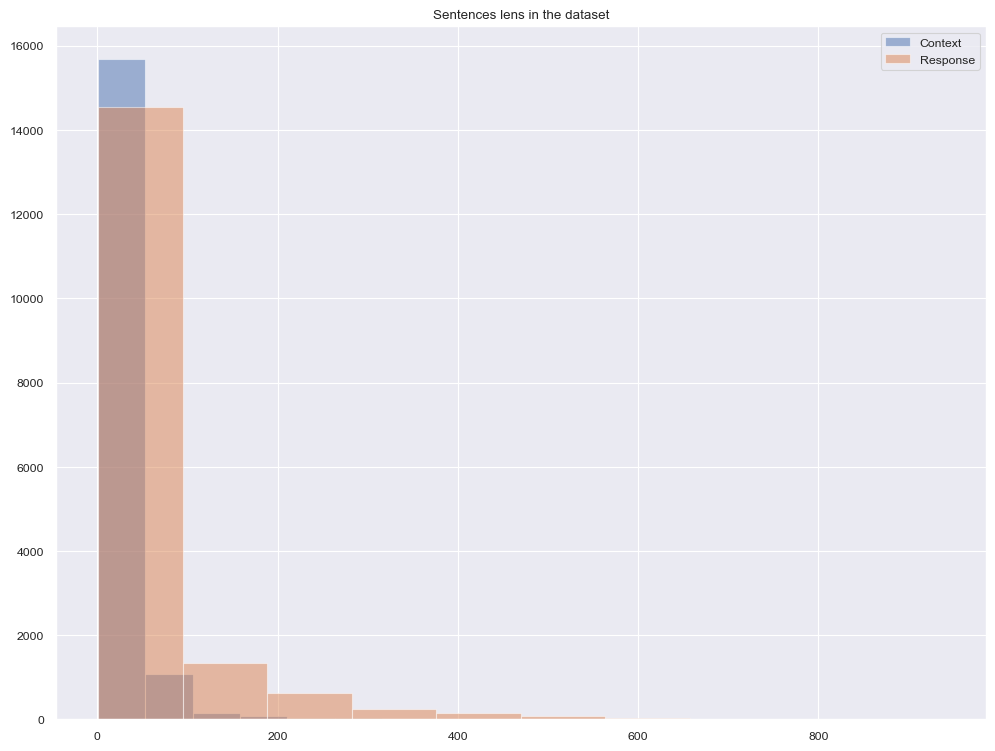

In [12]:
sns.set('paper')

plt.figure(figsize=(12, 9))

plt.hist(sentences_lens['context_lens'], label = 'Context', alpha = 0.5)
plt.hist(sentences_lens['response_lens'], label = 'Response', alpha = 0.5)

plt.title('Sentences lens in the dataset')

plt.legend()

Based on the distributions shown above, both exhibit a right-skewed pattern. Generally, context sentences tend not to exceed 100 words, while responses frequently fall below 300 words. 


To streamline model size and facilitate training, we propose truncating sentences longer than the 0.97 percentile length. This approach ensures our model focuses on the most representative data points, enhancing efficiency without compromising performance.

In [13]:
q_97 = sentences_lens.quantile(0.97)
print('Q97 quantiles:', q_97)

accepted_idx = sentences_lens.loc[(sentences_lens['context_lens'] <= q_97['context_lens']) & (sentences_lens['response_lens'] <= q_97['response_lens'])].index

sentences_lens = sentences_lens.iloc[accepted_idx, :]

df = df.iloc[accepted_idx, :].reset_index(drop = True)

Q97 quantiles: context_lens      85.0
response_lens    289.0
Name: 0.97, dtype: float64


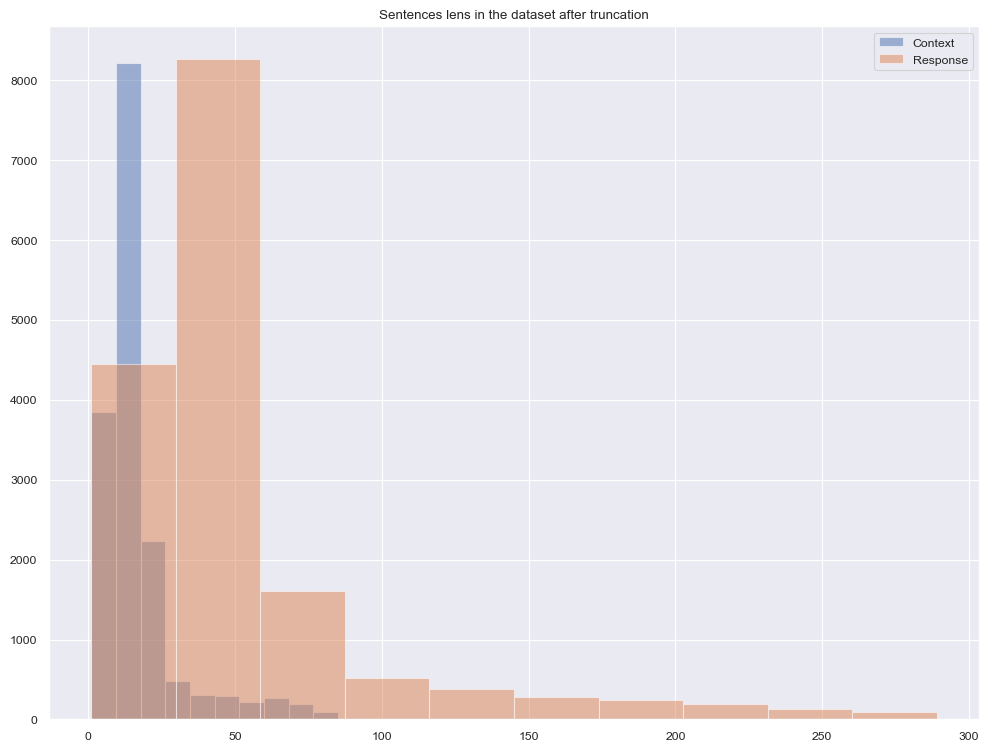

In [14]:

plt.figure(figsize=(12, 9))

plt.hist(sentences_lens['context_lens'], label = 'Context', alpha = 0.5)
plt.hist(sentences_lens['response_lens'], label = 'Response', alpha = 0.5)

plt.title('Sentences lens in the dataset after truncation')

plt.legend()

# Wordcloud

A word cloud is a visualization technique used in Natural Language Processing (NLP) to represent text data. It displays the most frequently occurring words in a corpus, where the size of each word is proportional to its frequency of occurrence.

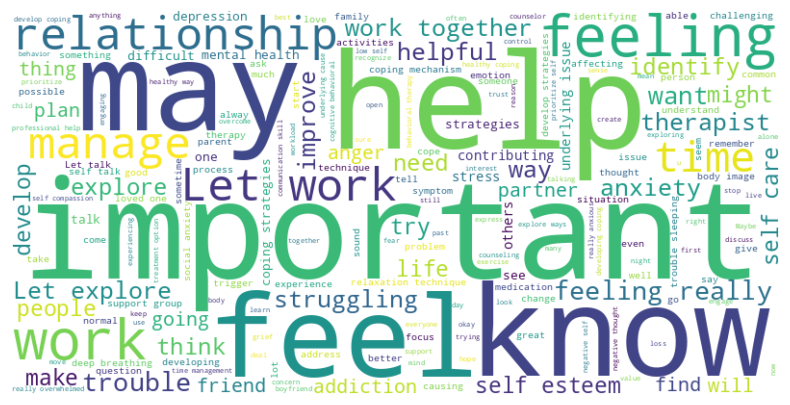

In [15]:
combined_text = ' '.join(df['Context']) + ' ' + ' '.join(df['Response'])



wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can see on the figure above, most of the words in Wordcloud are related to emotions. We can also notice that the largest  words are related to subjective feelings. This all indicates that the text is likely discussing or expressing feelings, opinions, or personal experiences rather than presenting factual information (what is consistent to the nature of source of this dataset).

# Text data normalization

Normalization of text might be very useful to train models. It reduces noise and when number of training data is limited, it may also improve overall performance. But abandoning these benefits, the decision was made to not to normalize the dataset! The reason for this is a need to preserve the authenticity and diversity of the dataset. By maintaining the original text without normalization, the model can better capture the nuances and variations present in real-world data. This decision was driven by the desire to ensure that the trained model reflects the natural language patterns and idiosyncrasies encountered in the target domain or application. While normalization can offer advantages in certain contexts, in this case, prioritizing raw data integrity was deemed more valuable for the intended purpose.

# Split and save locally dataset

We're dividing the collected data into two distinct subsets: training and testing, with a ratio of 95% for training and 5% for testing. While this split ratio might seem unconventional, in this particular task, the final evaluation of the model will be conducted manually rather than relying solely on metrics. Given our limited number of training samples, each one is invaluable. Moreover, with over 800 samples, the test dataset's size is reasonably robust.


Training dataset will be later splitted into validation to ensure that overfitting is not present.

In [16]:
dataset = Dataset.from_pandas(df)

train_size = 0.95

train_ds_size = int(train_size * len(dataset))
test_ds_size = len(dataset) - train_ds_size

print('Number of training instances:', train_ds_size)
print('Number of test instances:', test_ds_size)


np.random.seed(2024)
indices = np.random.permutation(len(dataset))


train_indices = indices[:train_ds_size]
test_indices = indices[train_ds_size:]


train_dataset = dataset.select(train_indices)
test_dataset = dataset.select(test_indices)


train_dataset.to_parquet('MH_train.parquet')
test_dataset.to_parquet('MH_test.parquet')


Number of training instances: 15334
Number of test instances: 808


Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

327628

# References

[1] Amod, *mental_health_counseling_conversations*, Retrieved from https://huggingface.co/datasets/Amod/mental_health_counseling_conversations, Accesed 12.06.2024.

[2] Alexandreteles, *mental-health-conversational-data*, Retrieved from https://huggingface.co/datasets/alexandreteles/mental-health-conversational-data, Accesed 15.06.2024.

[3] Allenai, *prosocial-dialog*, Retrieved from https://huggingface.co/datasets/allenai/prosocial-dialog, Accesed 15.06.2024.

[4] Heliosbrahma, *mental_healt_conversational_dataset*, Retrieved from https://huggingface.co/datasets/heliosbrahma/mental_health_conversational_dataset, Accesed 15.06.2024.

[5] Samhog, *psychology-10k*, Retrieved from https://huggingface.co/datasets/samhog/psychology-10k, Accesed 15.06.2024.

[6] Jkhedri, *psychology-dataset*, Retrieved from https://huggingface.co/datasets/jkhedri/psychology-dataset, Accesed 15.06.2024.

[7] Marmikpandya, *mental-health*, Retrieved from https://huggingface.co/datasets/marmikpandya/mental-health, Accesed 15.06.2024.

[8] KelvinTichana2, *mentalhealthcurated*, Retrieved from https://huggingface.co/datasets/KelvinTichana2/mentalhealthcurated, Accesed 15.06.2024.

